In [2]:
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
from typing import Optional
from typing import Tuple
import seaborn as sns
import numpy as np
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

pygame 2.5.2 (SDL 2.28.2, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


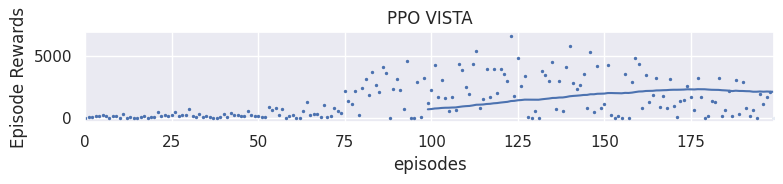

In [112]:
log_dir1 = "/mnt/persistent/lane-follow-ppo/tmp_1"
log_dir2 = "/mnt/persistent/lane-follow-ppo/tmp_2"
log_dir3 = "/mnt/persistent/lane-follow-ppo/tmp_3"
log_dir4 = "/mnt/persistent/lane-follow-ppo/tmp_4"
log_dir7 = "/mnt/persistent/lane-follow-ppo/tmp_7" # took 70 mins to train
log_dir9 = "/mnt/persistent/lane-follow-ppo/tmp_9"
log_dir10 = "/mnt/persistent/lane-follow-ppo/tmp_10"
log_dir11 = "/mnt/persistent/lane-follow-ppo/tmp_11"
log_dir12 = "/mnt/persistent/lane-follow-ppo/tmp_12"
log_dir30 = "/mnt/persistent/lane-follow-ppo/tmp_30"
log_dir31 = "/mnt/persistent/lane-follow-ppo/tmp_31"
log_dir32 = "/mnt/persistent/lane-follow-ppo/tmp_32"
log_dir33 = "/mnt/persistent/lane-follow-ppo/tmp_33"
timesteps = 500_000
plot_results([
    log_dir20
], timesteps, results_plotter.X_EPISODES, "PPO VISTA")
plt.show()

<Axes: xlabel='index', ylabel='course_completion_rate'>

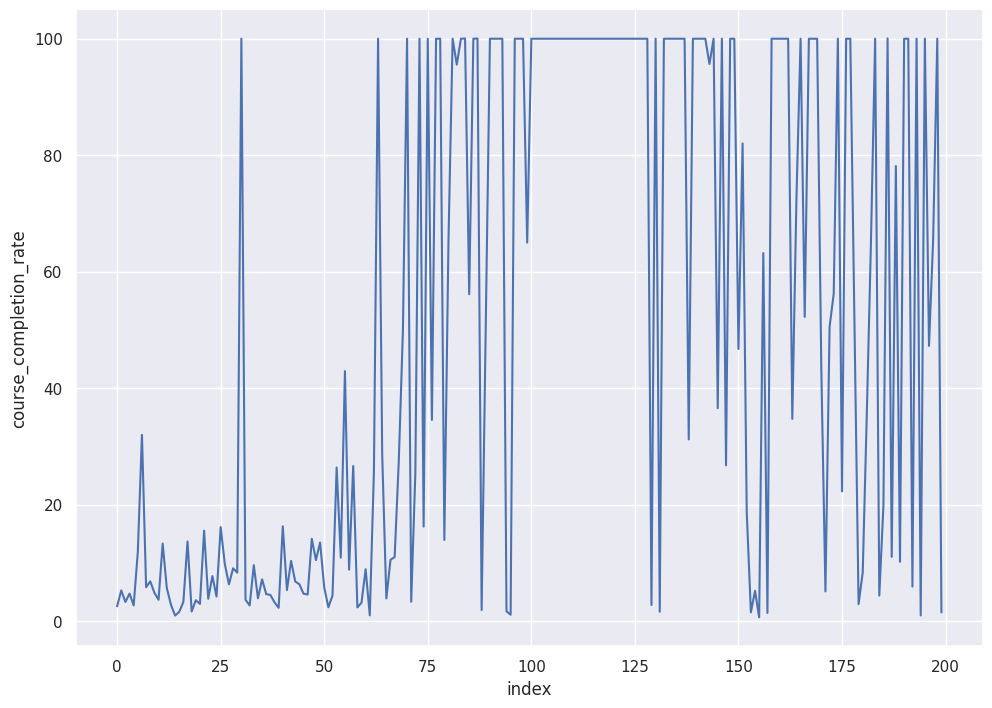

In [111]:
df = pd.read_csv(log_dir20 + "/monitor.csv", header=1).reset_index()
q = df["course_completion_rate"].quantile(0.99)
df = df[df["course_completion_rate"] < q]
sns.lineplot(df,x="index",y="course_completion_rate")

In [114]:
df9 = pd.read_csv(log_dir9 + "/monitor.csv", header=1).reset_index()
df9['Algorithm'] = 'PPO'
df10 = pd.read_csv(log_dir10 + "/monitor.csv", header=1).reset_index()
df10['Algorithm'] = 'PPO'
df11 = pd.read_csv(log_dir11 + "/monitor.csv", header=1).reset_index()
df11['Algorithm'] = 'PPO'
df12 = pd.read_csv(log_dir12 + "/monitor.csv", header=1).reset_index()
df12['Algorithm'] = 'PPO'
df_concat = pd.concat([df9, df10, df11, df12])
df_concat = df_concat.rename(columns={'index': 'Episode', 'course_completion_rate': 'Course Completion Rate'})
df_concat['NN'] =  '256 units'

In [117]:
df30 = pd.read_csv(log_dir30 + "/monitor.csv", header=1).reset_index()
df30['Algorithm'] = 'PPO'

df31 = pd.read_csv(log_dir31 + "/monitor.csv", header=1).reset_index()
df31['Algorithm'] = 'PPO'
q = df31["course_completion_rate"].quantile(0.99)
df31 = df31[df31["course_completion_rate"] < q]

df32 = pd.read_csv(log_dir32 + "/monitor.csv", header=1).reset_index()
df32['Algorithm'] = 'PPO'
q = df32["course_completion_rate"].quantile(0.99)
df32 = df32[df32["course_completion_rate"] < q]

df33 = pd.read_csv(log_dir33 + "/monitor.csv", header=1).reset_index()
df33['Algorithm'] = 'PPO'
q = df33["course_completion_rate"].quantile(0.99)
df33 = df33[df33["course_completion_rate"] < q]
df_concat_og = pd.concat([
    df30, 
    df31, 
    df32,
    df33,
])
df_concat_og = df_concat_og.rename(columns={'index': 'Episode', 'course_completion_rate': 'Course Completion Rate'})
df_concat_og['NN'] = 'Newer params'

<Axes: xlabel='Episode', ylabel='Course Completion Rate'>

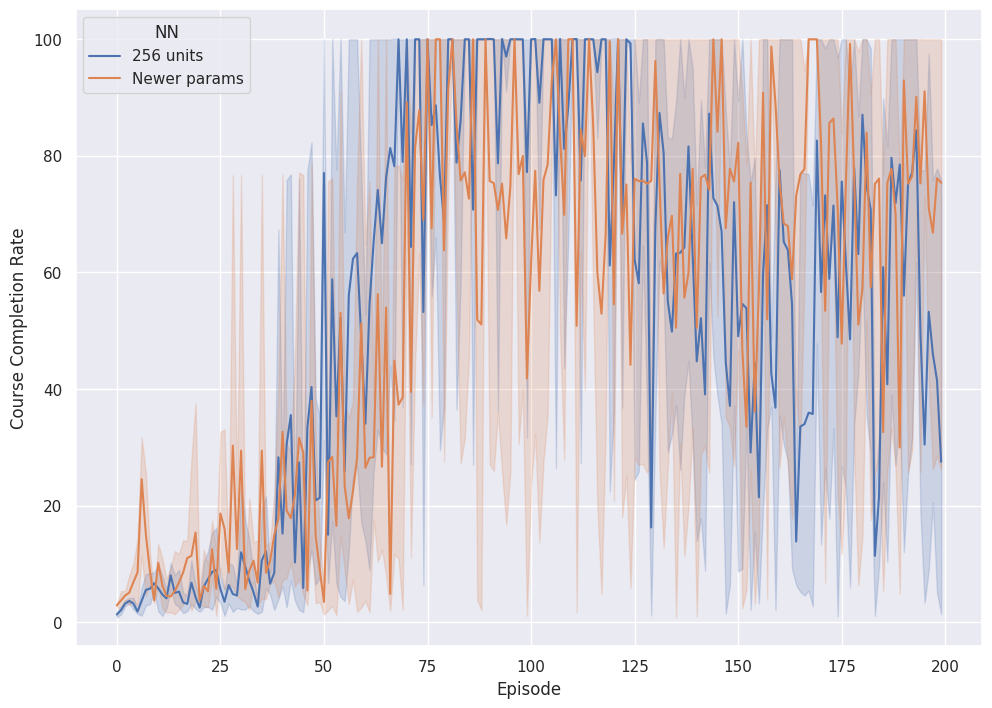

In [118]:
df_nn = pd.concat([df_concat, df_concat_og])
sns.lineplot(df_nn, x='Episode', y='Course Completion Rate', hue='NN')

In [7]:
fig = p.get_figure()
fig.savefig("ppo-sample.pdf")

In [46]:
import os
os.environ["DISPLAY"] = ":2"
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('VistaEnv.py'))))
from VistaEnv import VistaEnv
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('CustomCNN.py'))))
from CustomCNN import CustomCNN
import copy
import time
from typing import Callable

import torch
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor, VecFrameStack
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes

device = ("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device(device)
print(f"Using {device} device")

def make_env(rank: int, seed: int = 0):
    """
    Utility function for multiprocessed env.

    :param num_env: the number of environments you wish to have in subprocesses
    :param seed: the inital seed for RNG
    :param rank: index of the subprocess
    """
    def _init():
        # Initialize the simulator
        trace_config = dict(
            road_width=4,
            reset_mode='default',
            master_sensor='camera_front',
        )
        car_config = dict(
            length=5.,
            width=2.,
            wheel_base=2.78,
            steering_ratio=14.7,
            lookahead_road=True,
        )
        camera_config = {'type': 'camera',
                         'name': 'camera_front',
                         'rig_path': './RIG.xml',
                         'optical_flow_root': '../data_prep/Super-SloMo/slowmo',
                         'size': (400, 640)}
        ego_car_config = copy.deepcopy(car_config)
        ego_car_config['lookahead_road'] = True
        trace_root = "vista_traces"
        trace_path = [
            "20210726-154641_lexus_devens_center", 
            "20210726-155941_lexus_devens_center_reverse", 
            "20210726-184624_lexus_devens_center", 
            "20210726-184956_lexus_devens_center_reverse", 
        ]
        trace_paths = [os.path.join(trace_root, p) for p in trace_path]
        display_config = dict(road_buffer_size=1000, )
        preprocess_config = {
            "crop_roi": True,
            "resize": True,
            "grayscale": True,
            "binary": False
        }
        env = VistaEnv(trace_paths = trace_paths, 
               trace_config = trace_config,
               car_config = car_config,
               display_config = display_config,
               preprocess_config = preprocess_config,
               sensors_configs = [camera_config])
        env.set_seed(seed + rank)
        env.reset()
        return env
    set_random_seed(seed + rank)
    time.sleep(1)
    return _init

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

learning_configs = {
    "policy_type": CustomCNN,
    "total_timesteps": 500_000,
    "env_id": "VISTA",
    "learning_rate": linear_schedule(0.0001),
    "n_steps": 256,
    "batch_size": 256,
    "ent_coef": 0.01,
}

# Stops training when the model reaches the maximum number of episodes
callback_max_episodes = StopTrainingOnMaxEpisodes(max_episodes=25, verbose=1)
torch.cuda.empty_cache()
num_cpu = 8
vec_env = SubprocVecEnv([make_env(i) for i in range(num_cpu)])
vec_env = VecFrameStack(vec_env, n_stack=4)
obs = vec_env.reset()
obs.shape

Using cuda:1 device


2024-05-16 16:40:59,452::WARNING::[vista.entities.sensors.EventCamera.<module>] Fail to import module for event camera. Remember to do source <some-dir>/openeb/build/utils/scripts/setup_env.shCan ignore this if not using it
2024-05-16 16:40:59,490::WARNING::[vista.entities.sensors.EventCamera.<module>] Fail to import module for event camera. Remember to do source <some-dir>/openeb/build/utils/scripts/setup_env.shCan ignore this if not using it
2024-05-16 16:40:59,495::WARNING::[vista.entities.sensors.EventCamera.<module>] Fail to import module for event camera. Remember to do source <some-dir>/openeb/build/utils/scripts/setup_env.shCan ignore this if not using it
2024-05-16 16:40:59,523::WARNING::[vista.entities.sensors.EventCamera.<module>] Fail to import module for event camera. Remember to do source <some-dir>/openeb/build/utils/scripts/setup_env.shCan ignore this if not using it
2024-05-16 16:40:59,572::WARNING::[vista.entities.sensors.EventCamera.<module>] Fail to import module fo

(8, 4, 84, 84)

Process ForkServerProcess-12:
Traceback (most recent call last):
  File "/home/user/miniconda3/envs/vista/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/user/miniconda3/envs/vista/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/miniconda3/envs/vista/lib/python3.8/site-packages/stable_baselines3/common/vec_env/subproc_vec_env.py", line 33, in _worker
    cmd, data = remote.recv()
  File "/home/user/miniconda3/envs/vista/lib/python3.8/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/user/miniconda3/envs/vista/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/home/user/miniconda3/envs/vista/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Process ForkServerProcess-15:
Traceback (most recent call last